# Package

In [1]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from skimage.feature import hog

from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Process Data

In [3]:
class_name_path = "/content/drive/MyDrive/dataset/train"
ClassName = os.listdir(class_name_path)

ClassName

['traffic_light', 'zebra_crossing', 'double_yellow_lines', 'nothing', 'bus']

In [4]:
flat_data_arr_train=[] # training input array
flat_data_arr_test=[] # test input array

target_arr_train=[] # train output array
target_arr_test=[] # test output array

datadir="/content/drive/MyDrive/dataset/"
# path which contains all the categories of images
for i in ClassName:
    print(f'loading... category : {i}')
    # training
    training_path=os.path.join(datadir, 'train', i)
    for img in os.listdir(training_path):
        img_array=imread(os.path.join(training_path,img))
        flat_data_arr_train.append(img_array.flatten())
        target_arr_train.append(ClassName.index(i))

    # test
    test_path=os.path.join(datadir, 'test', i)
    for img in os.listdir(test_path):
        img_array=imread(os.path.join(test_path,img))
        flat_data_arr_test.append(img_array.flatten())
        target_arr_test.append(ClassName.index(i))
    print(f'loaded category:{i} successfully')
    print()

flat_data_train=np.array(flat_data_arr_train)
target_train=np.array(target_arr_train)
df_train=pd.DataFrame(flat_data_train) #dataframe
df_train['Target']=target_train
x_train=df_train.iloc[:,:-1] # training input data
y_train=df_train.iloc[:,-1] # training output data

flat_data_test=np.array(flat_data_arr_test)
target_test=np.array(target_arr_test)
df_test=pd.DataFrame(flat_data_test)
df_test["Target"]=target_test
x_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

# print(df_train)
# print(df_test)

loading... category : traffic_light
loaded category:traffic_light successfully

loading... category : zebra_crossing
loaded category:zebra_crossing successfully

loading... category : double_yellow_lines
loaded category:double_yellow_lines successfully

loading... category : nothing
loaded category:nothing successfully

loading... category : bus
loaded category:bus successfully



# common function

In [5]:
def retrieve_info(cluster_labels,y_train):
  # Initializing
  reference_labels = {}
  # For loop to run through each label of cluster label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels==i, 1, 0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num

  return reference_labels

In [6]:
def compute_kmeans_score(model, kmean_labels, y_train, x_test, y_test):
  # get reference label
  reference_labels = retrieve_info(kmeans.labels_,y_train)

  # training score
  train_labels = np.random.rand(len(kmeans.labels_))
  for i in range(len(kmeans.labels_)):
    train_labels[i] = reference_labels[kmeans.labels_[i]]

  train_score = accuracy_score(train_labels, y_train)

  # test score
  pre = kmeans.predict(x_test)
  test_labels = []
  for i in pre:
    test_labels.append(reference_labels[i])

  test_labels = np.array(test_labels)
  test_score = accuracy_score(test_labels,y_test)

  return train_score, test_score

In [7]:
def cross_validation(model, x_train, y_train, cv = 5):

  cvs = 0
  record = []
  num_val_samples = len(x_train)//cv

  for i in range(cv):
      val_data = x_train[i*num_val_samples : (i+1)*num_val_samples]
      val_targets = y_train[i*num_val_samples : (i+1)*num_val_samples]

      remaining_data = np.concatenate(
                          [x_train[: i*num_val_samples],
                          x_train[(i+1)*num_val_samples :]],
                          axis = 0)
      remaining_targets = np.concatenate(
                          [y_train[: i*num_val_samples],
                          y_train[(i+1)*num_val_samples :]],
                          axis = 0)
      # print(i)
      # print(remaining_data.shape)
      # print(remaining_targets.shape)
      model.fit(remaining_data, remaining_targets)
      train_score, test_score = compute_kmeans_score(model, model.labels_,
                               remaining_targets, val_data, val_targets)
      record.append(test_score)

  for i in record:
    cvs += (i/cv)

  return test_score

# origion

best_algorithm: lloyd
best_k: 120
best_score: 0.5


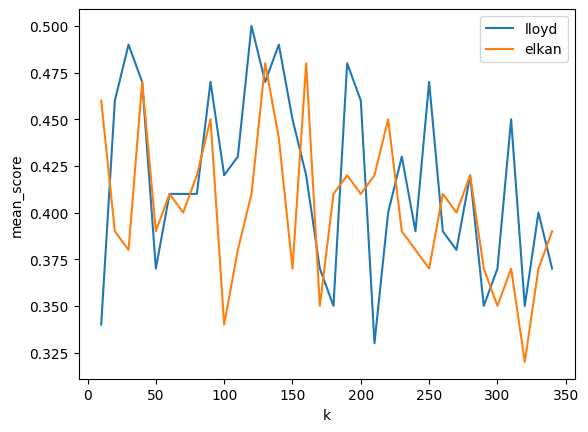

In [ ]:
k = range(10, 350, 10)
llo_score = []
elk_score = []
best_score = 0
best_k = 0
best_algorithm = ""

for a in ["lloyd", "elkan"]:
  for i in k:
    kmeans = KMeans(algorithm = a, n_init = 'auto', n_clusters = i)
    now_score = cross_validation(kmeans, x_train, y_train, cv = 5)
    if(a == "lloyd"): llo_score.append(now_score)
    else: elk_score.append(now_score)

    if(now_score > best_score):
      best_algorithm = a
      best_score = now_score
      best_k = i

print(f"best_algorithm: {best_algorithm}")
print(f"best_k: {best_k}")
print(f"best_score: {best_score}")

plt.plot()
lloyd, = plt.plot(k, llo_score, label = 'lloyd')
elkan, = plt.plot(k, elk_score, label = 'elkan')
plt.xlabel('k')
plt.ylabel('mean_score')
plt.legend(handles = [lloyd, elkan], loc='upper right')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 120)
kmeans.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=120)

In [ ]:
train_score, test_score = compute_kmeans_score(kmeans, kmeans.labels_, y_train, x_test, y_test)

In [ ]:
print(train_score)
print(test_score)

0.6475
0.37


# PCA

In [8]:
pca = PCA(n_components=0.85)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

best_algorithm: lloyd
best_k: 20
best_score: 0.56


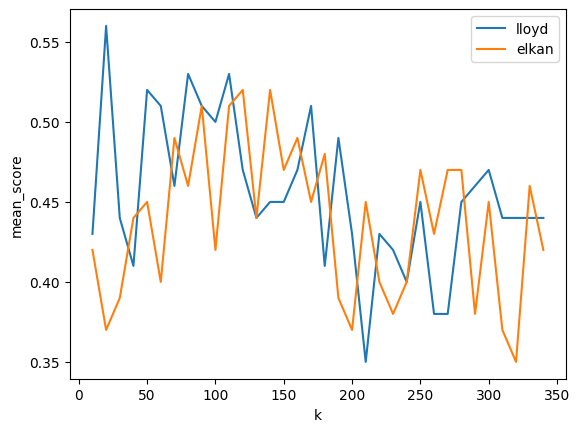

In [9]:
k = range(10, 350, 10)
llo_score = []
elk_score = []
best_score = 0
best_k = 0
best_algorithm = ""

for a in ["lloyd", "elkan"]:
  for i in k:
    kmeans = KMeans(algorithm = a, n_init = 'auto', n_clusters = i)
    now_score = cross_validation(kmeans, x_train_pca, y_train, cv = 5)
    if(a == "lloyd"): llo_score.append(now_score)
    else: elk_score.append(now_score)

    if(now_score > best_score):
      best_algorithm = a
      best_score = now_score
      best_k = i

print(f"best_algorithm: {best_algorithm}")
print(f"best_k: {best_k}")
print(f"best_score: {best_score}")

plt.plot()
lloyd, = plt.plot(k, llo_score, label = 'lloyd')
elkan, = plt.plot(k, elk_score, label = 'elkan')
plt.xlabel('k')
plt.ylabel('mean_score')
plt.legend(handles = [lloyd, elkan], loc='upper right')
plt.show()

In [17]:
kmeans = KMeans(n_clusters = 20)
kmeans.fit(x_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=20)

In [18]:
train_score, test_score = compute_kmeans_score(kmeans, kmeans.labels_, y_train, x_test_pca, y_test)

In [19]:
print(train_score)
print(test_score)

0.5125
0.43


# HOG

In [10]:
imgs = []
gray_img = []
hog_img = []
hog_feature_train = []
hog_feature_test = []
target_arr_train=[] # train output array
target_arr_test=[] # test output array

datadir="/content/drive/MyDrive/dataset/"
# path which contains all the categories of images
for i in ClassName:
    print(f'loading... category : {i}')
    # training
    training_path=os.path.join(datadir, 'train', i)
    for img_ in os.listdir(training_path):
        img = imread(os.path.join(training_path,img_))
        img_gray = color.rgb2gray(img)
        hog_vec, hog_vis = hog(img_gray, visualize=True)

        imgs.append(img)
        gray_img.append(img_gray)
        hog_img.append(hog_vis)
        hog_feature_train.append(hog_vec)
        target_arr_train.append(ClassName.index(i))

    # test
    test_path=os.path.join(datadir, 'test', i)
    for img_ in os.listdir(test_path):
        img = imread(os.path.join(test_path,img_))
        img_gray = color.rgb2gray(img)
        hog_vec, hog_vis = hog(img_gray, visualize=True)

        imgs.append(img)
        gray_img.append(img_gray)
        hog_img.append(hog_vis)
        hog_feature_test.append(hog_vec)
        target_arr_test.append(ClassName.index(i))
    print(f'loaded category:{i} successfully')
    print()

hog_feature_train = np.array(hog_feature_train)
target_train = np.array(target_arr_train)
df_train_hog = pd.DataFrame(hog_feature_train) #dataframe
df_train_hog['Target'] = target_train
x_train_hog=df_train_hog.iloc[:,:-1] # training input data
y_train=df_train_hog.iloc[:,-1] # training output data

hog_feature_test = np.array(hog_feature_test)
target_test=np.array(target_arr_test)
df_test_hog=pd.DataFrame(hog_feature_test)
df_test_hog["Target"]=target_test
x_test_hog=df_test_hog.iloc[:,:-1]
y_test=df_test_hog.iloc[:,-1]

loading... category : traffic_light
loaded category:traffic_light successfully

loading... category : zebra_crossing
loaded category:zebra_crossing successfully

loading... category : double_yellow_lines
loaded category:double_yellow_lines successfully

loading... category : nothing
loaded category:nothing successfully

loading... category : bus
loaded category:bus successfully



best_algorithm: elkan
best_k: 70
best_score: 0.69


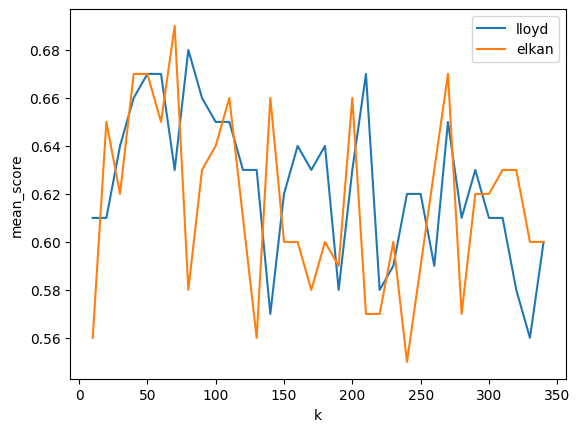

In [11]:
k = range(10, 350, 10)
llo_score = []
elk_score = []
best_score = 0
best_k = 0
best_algorithm = ""

for a in ["lloyd", "elkan"]:
  for i in k:
    kmeans = KMeans(algorithm = a, n_init = 'auto', n_clusters = i)
    now_score = cross_validation(kmeans, x_train_hog, y_train, cv = 5)
    if(a == "lloyd"): llo_score.append(now_score)
    else: elk_score.append(now_score)

    if(now_score > best_score):
      best_algorithm = a
      best_score = now_score
      best_k = i

print(f"best_algorithm: {best_algorithm}")
print(f"best_k: {best_k}")
print(f"best_score: {best_score}")

plt.plot()
lloyd, = plt.plot(k, llo_score, label = 'lloyd')
elkan, = plt.plot(k, elk_score, label = 'elkan')
plt.xlabel('k')
plt.ylabel('mean_score')
plt.legend(handles = [lloyd, elkan], loc='upper right')
plt.show()

In [35]:
kmeans = KMeans(algorithm = "elkan", n_clusters = 70)
kmeans.fit(x_train_hog, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(algorithm='elkan', n_clusters=70)

In [36]:
train_score, test_score = compute_kmeans_score(kmeans, kmeans.labels_, y_train, x_test_hog, y_test)

In [37]:
print(train_score)
print(test_score)

0.76
0.66


# HOG + PCA

In [12]:
pca = PCA(n_components=0.85)
pca.fit(x_train_hog)

x_train_hog_pca = pca.transform(x_train_hog)
x_test_hog_pca = pca.transform(x_test_hog)

best_algorithm: elkan
best_k: 60
best_score: 0.73


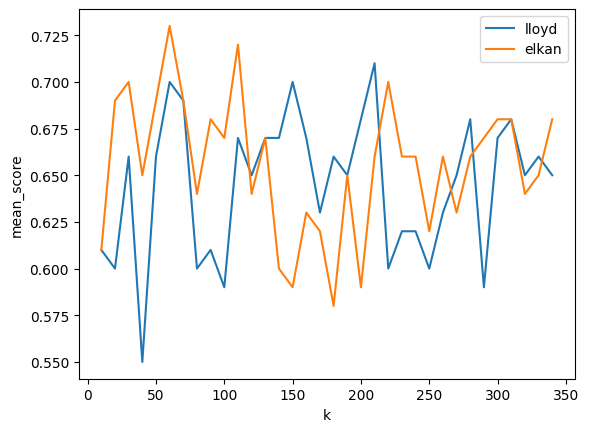

In [13]:
k = range(10, 350, 10)
llo_score = []
elk_score = []
best_score = 0
best_k = 0
best_algorithm = ""

for a in ["lloyd", "elkan"]:
  for i in k:
    kmeans = KMeans(algorithm = a, n_init = 'auto', n_clusters = i)
    now_score = cross_validation(kmeans, x_train_hog_pca, y_train, cv = 5)
    if(a == "lloyd"): llo_score.append(now_score)
    else: elk_score.append(now_score)

    if(now_score > best_score):
      best_algorithm = a
      best_score = now_score
      best_k = i

print(f"best_algorithm: {best_algorithm}")
print(f"best_k: {best_k}")
print(f"best_score: {best_score}")

plt.plot()
lloyd, = plt.plot(k, llo_score, label = 'lloyd')
elkan, = plt.plot(k, elk_score, label = 'elkan')
plt.xlabel('k')
plt.ylabel('mean_score')
plt.legend(handles = [lloyd, elkan], loc='upper right')
plt.show()

In [50]:
kmeans = KMeans(algorithm = "elkan", n_clusters = 60)
kmeans.fit(x_train_hog_pca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(algorithm='elkan', n_clusters=60)

In [51]:
train_score, test_score = compute_kmeans_score(kmeans, kmeans.labels_, y_train, x_test_hog_pca, y_test)

In [52]:
print(train_score)
print(test_score)

0.745
0.69
